En este notebook vamos a proponer algunos ejercicios sobre modelos de aprendizaje no supervisado utilizando un nuevo dataset.

#  *Credit Card* [Dataset](https://www.kaggle.com/datasets/arjunbhasin2013/ccdata)

In [155]:
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.2 MB 11.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2342162 sha256=d305853d136ce1a93df777c1d568b84b0d4090298835cac41091c149ac24f3f5
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan


In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
warnings.filterwarnings("ignore")
import matplotlib as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from mpl_toolkits import mplot3d
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from hdbscan import HDBSCAN





In [158]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [159]:
# El primer paso como en todos los problemas es cargar los datos para tenerlos disponibles
df = pd.read_csv('/content/drive/MyDrive/19 07 2023 cluster/CC_GENERAL.csv')

In [160]:
# vamos a hacer un poco de exploración de los datos que tenemos, empezando por ver las primeras filas de datos
# que tenemos para hacernos una idea de los datos con los que contamos
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [161]:
# vamos a ver qué información nos puede proporcionar Pandas sobre los datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

Podemos ver que es un dataset relativamente limpio y que tiene la mayoría de sus filas con datos. Más adelante empezaremos a tratar los datos para dejarlos listos para poder utilizarlos en nuestro modelo. 


Este dataset nos presenta un problema en el que necesitamos segmentar los clientes que estan utilizando sus tarjetas de crédito para definir una estrategia de marketing para los distintos grupos de clientes que podamos identificar. 

Es un problema de clustering como el que hemos visto en la teoría y crearemos un modelo de K-Means para identificar esos grupos (clusters) de clientes. 

In [162]:
# dado que es un dataset nuevo vamos a hacer un poco más de exploración de los datos
# Empecemos por ver más información que nos puede dar la libreria de Pandas sobre nuestros datos

df.describe().T

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000


In [163]:
# Vamos a verificar que no haya filas duplicadas en nuestros datos
df.duplicated().sum()

0

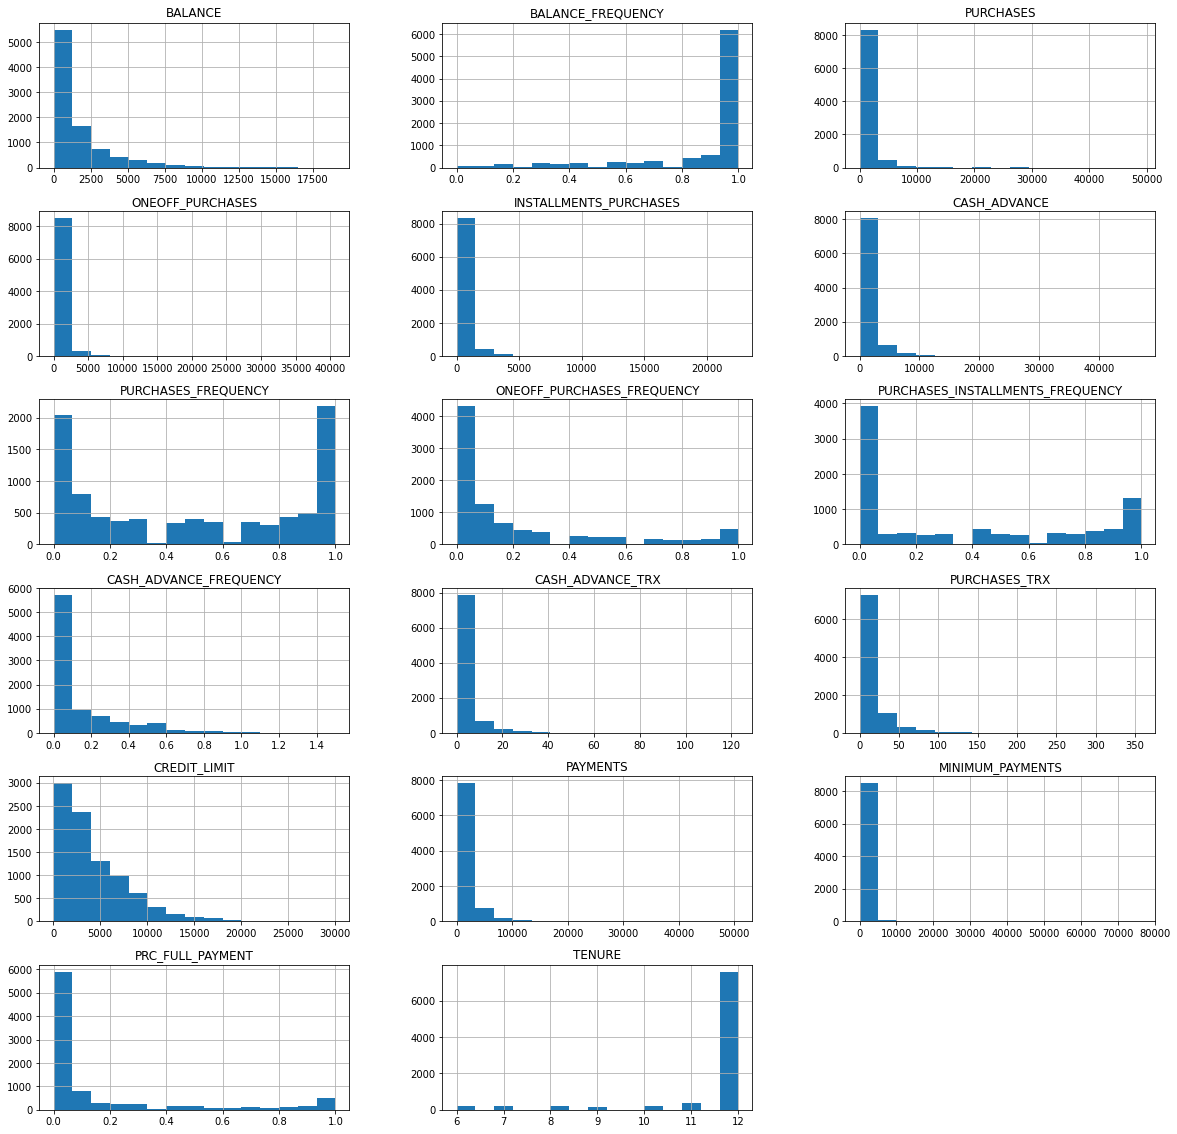

In [164]:
# vamos a ver una representación visual de las distintas variables. Solo podemos 
# ver las variables numéricas por lo que las seleccionaremos antes de hacer los gráficos
numerical_features=[feature for feature in df.columns if df[feature].dtypes!='object']

df[numerical_features].hist(bins=15, figsize=(20, 20), layout=(6, 3));

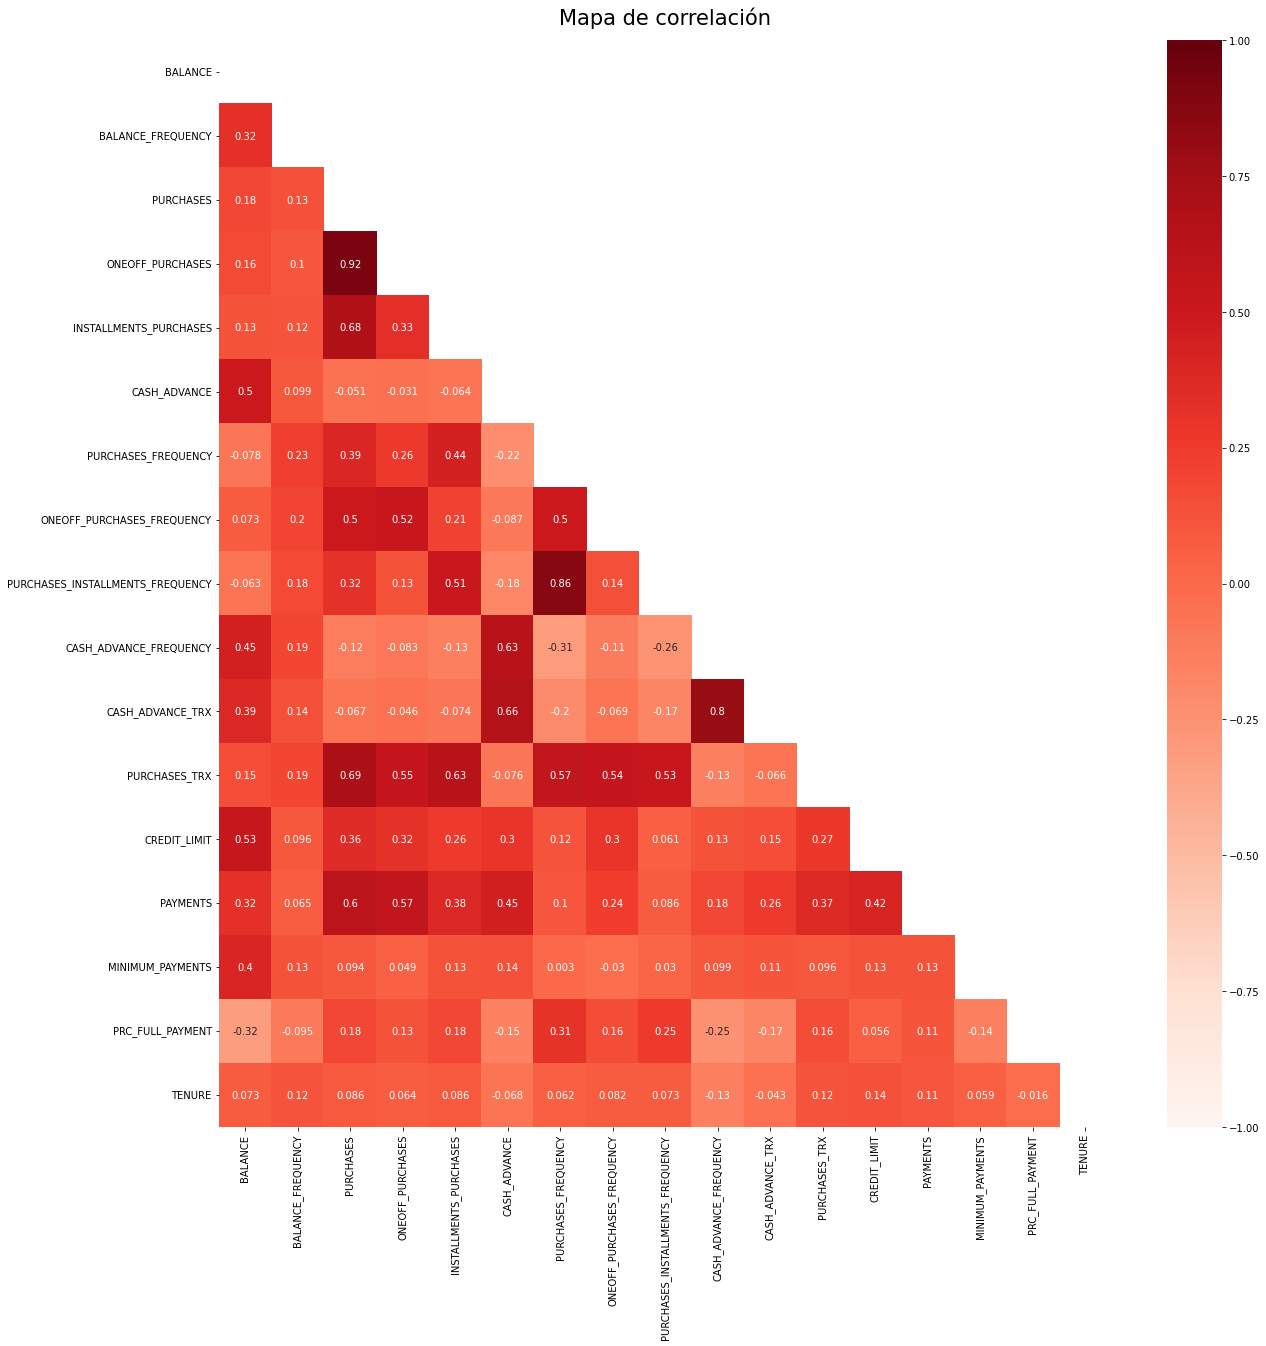

In [165]:
# A la hora de poder entender qué variables son las que están marcando la creación 
# de los distintos grupos (clusters) es interesante saber la correlación entre las distintas
# variables 
plt.subplots(figsize=(20,20))

mask = np.triu(np.ones_like(df.corr()))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='Reds')
heatmap.set_title('Mapa de correlación', fontdict={'fontsize':21}, pad=16);

Podemos ver ciertas correlaciones fuertes entre algunas variables, como por ejemplo entre ONEOFF_PURCHASES (máximo número de articulos comprados por un cliente en una única vez) y PURCHASES (número total de articulos comprados por un cliente) o entre CASH_ADVANCE_TRX (número de transacciones hechas con dinero adelantado) y CASH_ADVANCE_FREQUENCY (frecuencia en la que se utiliza dinero adelantado en las transacciones) como era de esperar. 

Hay otras correlaciones que podemos identificar y que nos pueden servir luego para sacar insights de nuestros grupos (clusters).

In [166]:
# Vamos a pasar al preprocesamiento de nuestros datos
# la columan de CUST_ID es categórica y redundante puesto que tiene el mismo valor que el índice de la columna
# por lo tanto vamos a eliminar esa columna

df = df.drop(columns=['CUST_ID'],axis=1)

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

In [168]:
# hemos visto que CREDIT_LIMIT y MINIMUM_PAYMENTS tienen filas vacías que tenemos que imputar. 
# vamos a optar por rellenar esos huecos vacíos con el valor medio de las variables afectadas

df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean(),inplace=True)
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean(),inplace=True)

In [169]:
# Dado que se trata de un problema de aprendizaje no supervisado donde los modelos se basan en 
# distancias para medir la pertenencia de los distintos puntos de datos a un grupo u otro, es muy 
# importante la utilización de un escalado en todas las variables para asegurarnos de que estas distancias
# no se vean afectadas por los valores de cada una de las variables. 

# Creamos el objeto del scaler que nos va a permitir escalar nuestros datos
scaler = StandardScaler()

col_names = df.columns

# aplicamos el scaler para que aprenda de nuestros datos y los transforme a una escala standard
df[col_names] = scaler.fit_transform(df[col_names].values)

In [170]:
# Si comparamos con la información que teníamos antes de hacer el escalado podemos ver el efecto del scaler 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.0,-2.540488e-17,1.000056,-0.751640,-0.690008,-0.332029,2.352559e-01,8.397489
BALANCE_FREQUENCY,8950.0,1.587805e-16,1.000056,-3.703271,0.049045,0.518084,5.180838e-01,0.518084
PURCHASES,8950.0,3.175610e-18,1.000056,-0.469552,-0.451001,-0.300454,5.004652e-02,22.483510
ONEOFF_PURCHASES,8950.0,-6.033659e-17,1.000056,-0.356934,-0.356934,-0.334040,-9.056763e-03,24.201066
INSTALLMENTS_PURCHASES,8950.0,3.175610e-17,1.000056,-0.454576,-0.454576,-0.356156,6.366321e-02,24.426889
CASH_ADVANCE,8950.0,-6.351220e-18,1.000056,-0.466786,-0.466786,-0.466786,6.435242e-02,22.011117
PURCHASES_FREQUENCY,8950.0,9.328354e-17,1.000056,-1.221758,-1.014125,0.024043,1.062211e+00,1.269843
ONEOFF_PURCHASES_FREQUENCY,8950.0,1.905366e-17,1.000056,-0.678661,-0.678661,-0.399319,3.269728e-01,2.673451
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,5.716098e-17,1.000056,-0.916995,-0.916995,-0.497629,9.701506e-01,1.599199
CASH_ADVANCE_FREQUENCY,8950.0,-1.595744e-16,1.000056,-0.675349,-0.675349,-0.675349,4.351492e-01,6.820521


In [171]:
# Vamos a empezar con la creación de nuestro modelo

kmean = KMeans(n_clusters= 2, random_state = 123 )

In [172]:
# Entrenamos nuestro modelo
kmean.fit(df)

KMeans(n_clusters=2, random_state=123)

In [173]:
# vamos a generar las etiquetas de nuestros grupos 
kmean.predict(df)

array([1, 1, 0, ..., 1, 1, 1], dtype=int32)

In [174]:
etiquetas = kmean.labels_

In [175]:
# definimos una nueva lista que va a tener el error de asignación de los clusters para cada valor de K

wcss = []

# Probamos diferentes valores de K 
for i in range(1,13):
  kmeans = KMeans(n_clusters=i, random_state=123)
  kmeans.fit(df)
  wcss.append(kmeans.inertia_)

In [176]:
wcss

[152149.99999999983,
 127785.04965248298,
 111986.69806610125,
 99073.93826774803,
 91502.97835947922,
 84852.59400226288,
 79532.32854113297,
 74624.46850432656,
 69978.93831935523,
 66461.97976672437,
 63645.30660769583,
 61352.78446324055]

In [177]:
import plotly.express as px
import plotly.graph_objects as go

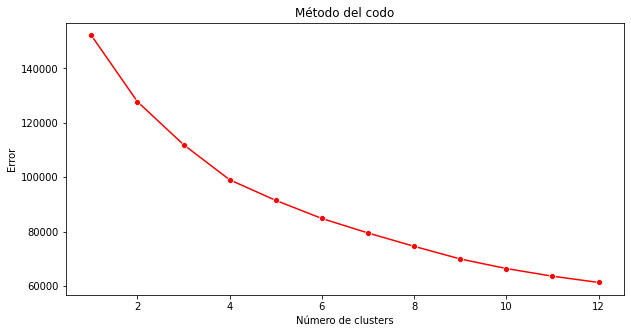

In [178]:
plt.figure(figsize=(10,5))
sns.lineplot(range(1, 13), wcss,marker='o',color='red')
plt.title('Método del codo')
plt.xlabel('Número de clusters')
plt.ylabel('Error')
plt.show()

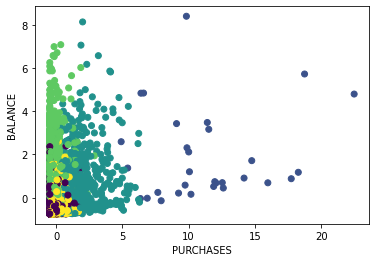

In [179]:
new_kmeans = KMeans(n_clusters=5)
new_kmeans.fit(df)
labels = new_kmeans.predict(df)

plt.scatter(df['PURCHASES'], df['BALANCE'], c=labels)
plt.xlabel('PURCHASES')
plt.ylabel('BALANCE')
plt.show()

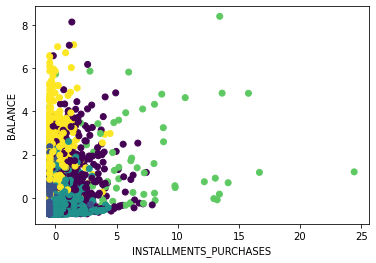

In [180]:
new_kmeans = KMeans(n_clusters=5)
new_kmeans.fit(df)
labels = new_kmeans.predict(df)

plt.scatter(df['INSTALLMENTS_PURCHASES'], df['BALANCE'], c=labels)
plt.xlabel('INSTALLMENTS_PURCHASES')
plt.ylabel('BALANCE')
plt.show()

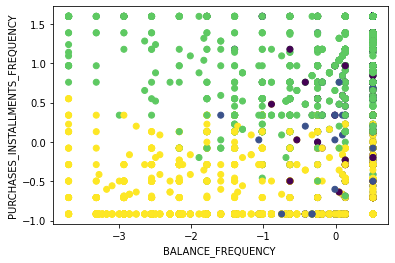

In [181]:
new_kmeans = KMeans(n_clusters=5)
new_kmeans.fit(df)
labels = new_kmeans.predict(df)

plt.scatter(df['BALANCE_FREQUENCY'], df['PURCHASES_INSTALLMENTS_FREQUENCY'], c=labels)
plt.xlabel('BALANCE_FREQUENCY ')
plt.ylabel('PURCHASES_INSTALLMENTS_FREQUENCY')
plt.show()

In [182]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from mpl_toolkits import mplot3d

In [183]:
df_cluster =  pd.DataFrame(columns = ['x','y'])

In [184]:
#Instanciamos
#___________________________________________________________
dbscan = DBSCAN(eps=0.033,
               min_samples=5,
               algorithm='brute',
               p=0.9)

#Entrenamos y predecimos
#___________________________________________________________
preds = dbscan.fit_predict(df)


#Métricas de Clustering
#___________________________________________________________

#nuesttro sihouette score (coeficiente de silueta) es malo
silhouette_score(df, preds)

#Nuestro harabasz score es bueno
calinski_harabasz_score(df, preds)

#Hacemos un plot de los resultados
#____________________________________________________________

2.0907792310214672

In [214]:
#df.plot(kind='scatter', 'df_cluster', 'df_cluster', c=preds, cmap='Accent_r', figsize=(16,10))

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
warnings.filterwarnings("ignore")
import matplotlib as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from mpl_toolkits import mplot3d
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from hdbscan import HDBSCAN

In [274]:
from sklearn.preprocessing import StandardScaler

In [275]:
df = pd.read_csv('/content/drive/MyDrive/19 07 2023 cluster/CC_GENERAL.csv')

In [276]:
df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean(),inplace=True)
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean(),inplace=True)
df = df.drop(columns=['CUST_ID'],axis=1)

In [277]:
scaler = StandardScaler()

In [278]:
col_names = df.columns

In [279]:
df[col_names] = scaler.fit_transform(df[col_names].values)

In [280]:
kmean = KMeans(n_clusters= 2, random_state = 123 )

In [281]:
kmean.fit(df)

KMeans(n_clusters=2, random_state=123)

In [282]:
kmean.predict(df)

array([1, 1, 0, ..., 1, 1, 1], dtype=int32)

In [283]:
etiquetas = kmean.labels_

In [284]:
clusters = pd.concat([df, pd.DataFrame({'cluster':etiquetas})], axis=1)
clusters.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,-0.731989,-0.249434,-0.424900,-0.356934,-0.349079,-0.466786,-0.806490,-0.678661,-0.707313,-0.675349,-0.476070,-0.511333,-0.960433,-0.528979,-3.109675e-01,-0.525551,0.36068,1
1,0.786961,0.134325,-0.469552,-0.356934,-0.454576,2.605605,-1.221758,-0.678661,-0.916995,0.573963,0.110074,-0.591796,0.688639,0.818642,8.931021e-02,0.234227,0.36068,1
2,0.447135,0.518084,-0.107668,0.108889,-0.454576,-0.466786,1.269843,2.673451,-0.916995,-0.675349,-0.476070,-0.109020,0.826062,-0.383805,-1.016632e-01,-0.525551,0.36068,0
3,0.049099,-1.016953,0.232058,0.546189,-0.454576,-0.368653,-1.014125,-0.399319,-0.916995,-0.258913,-0.329534,-0.551565,0.826062,-0.598688,4.878305e-17,-0.525551,0.36068,1
4,-0.358775,0.518084,-0.462063,-0.347294,-0.454576,-0.466786,-1.014125,-0.399319,-0.916995,-0.675349,-0.476070,-0.551565,-0.905464,-0.364368,-2.657913e-01,-0.525551,0.36068,1


In [285]:
clusters.groupby('cluster').agg(['mean', 'median']).T

cluster                                         0         1
BALANCE                          mean   -0.090374  0.064578
                                 median -0.506313 -0.235934
BALANCE_FREQUENCY                mean    0.286818 -0.204948
                                 median  0.518084  0.518084
PURCHASES                        mean    0.476354 -0.340383
                                 median  0.083477 -0.431172
ONEOFF_PURCHASES                 mean    0.329697 -0.235588
                                 median -0.134422 -0.356934
INSTALLMENTS_PURCHASES           mean    0.520339 -0.371813
                                 median  0.134517 -0.454576
CASH_ADVANCE                     mean   -0.258992  0.185065
                                 median -0.466786 -0.285012
PURCHASES_FREQUENCY              mean    1.031693 -0.737206
                                 median  1.269843 -1.014125
ONEOFF_PURCHASES_FREQUENCY       mean    0.534735 -0.382100
                                 median  0.159367 -0.678661
PURCHASES_INSTALLMENTS_FREQUENCY mean    0.918521 -0.656338
                                 median  1.179833 -0.916995
CASH_ADVANCE_FREQUENCY           mean   -0.383146  0.273780
                                 median -0.675349 -0.175624
CASH_ADVANCE_TRX                 mean   -0.269270  0.192409
                                 median -0.476070 -0.182998
PURCHASES_TRX                    mean    0.639919 -0.457260
                                 median  0.212830 -0.551565
CREDIT_LIMIT                     mean    0.163675 -0.116955
                                 median -0.135897 -0.410743
PAYMENTS                         mean    0.154625 -0.110489
                                 median -0.178647 -0.369874
MINIMUM_PAYMENTS                 mean    0.003158 -0.002257
                                 median -0.276219 -0.191186
PRC_FULL_PAYMENT                 mean    0.398873 -0.285018
                                 median -0.240635 -0.525551
TENURE                           mean    0.115472 -0.082512
                                 median  0.360680  0.360680

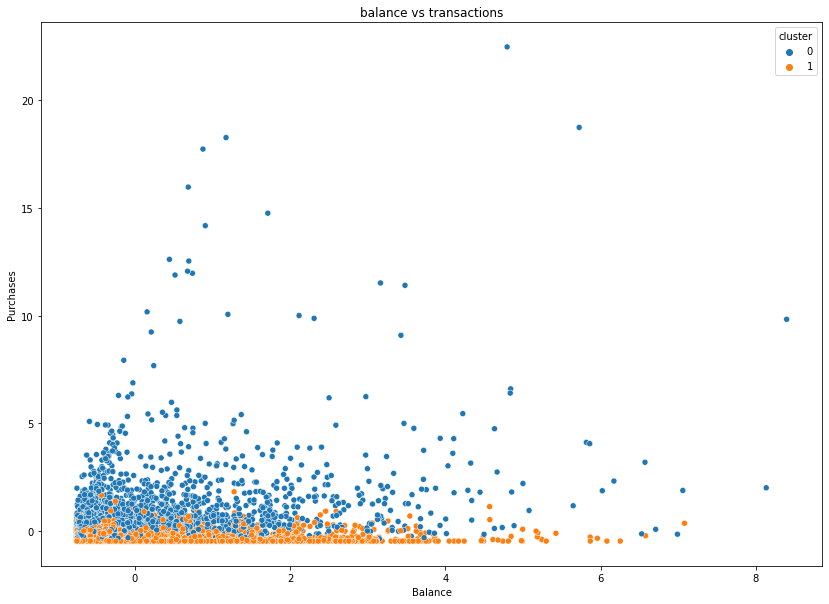

In [291]:
plt.figure(figsize=(14,10))
x = df['BALANCE']
y = df['PURCHASES']
g = sns.scatterplot(x, y, hue = clusters['cluster'])
g.set_xlabel('Balance')
g.set_ylabel('Purchases')
g.set_title('balance vs transactions')
plt.show()

In [220]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from mpl_toolkits import mplot3d

# Otros enfoques

Hemos completado el problema básico de segmentación de los clientes. Pero hay muchas mejoras que podemos aplicar a la solución que hemos desarrollado: 

- El número de clusters que hemos utilizado es un número arbitrario. ¿Puedes encontrar el número óptimo de clusters para los datos que disponemos? 

- Todos los pasos de preprocesamiento que hemos hecho están por separado y una de las buenas prácticas que vimos en la teoría es utilizar objetos de tipo Pipeline para agrupar este tipo de pasos. ¿Puedes transformar los pasos de preprocesamiento que hemos aplicado en este ejemplo para que se ejecuten dentro de un Pipeline? 

- Hemos tomado algunas decisiones sobre el preprocesamiento de los datos como la técnica que utilizamos para imputar los valores vacíos o el tipo de scaler que utilizamos para escalar nuestros datos. Existen otras opciones que podríamos haber aplicado. ¿Qué efecto tienen sobre los clusters que generamos si optamos por distintas opciones, como un MaxMinScaler?

- El modelo de KMeans te está dando las etiquetas de los distintos clusters, pero aún tenemos que sacar insights sobre esos clusters. ¿Puedes identificar los distintos clusters en nuestros datos basándote en las etiquetas que te da el modelo y obtener alguna característica que les distinga? 

- Como ya hemos visto, este módulo del bootcamp es una introducción al data science y por lo tanto no hacemos una revisión en detalle de todos los modelos que existen para resolver estos problemas. Si quieres seguir profundizando, existe otro modelo que se llama DBSCAN que puedes utilizar para intentar mejorar los clusters que podemos crear. Esta es la documentación oficial de scikit-learn sobre DBSCAN (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) y esta es una descripción de cómo funciona DBSCAN (https://github.com/christianversloot/machine-learning-articles/blob/main/performing-dbscan-clustering-with-python-and-scikit-learn.md). ¿Puedes crear un modelo utilizando DBSCA y comparar los resultados de los clusters con los que has obtenido antes con KMeans? 